In [1]:
import numpy as np


class MDP:
    '''A simple MDP class.  It includes the following members'''

    def __init__(self, T, R, discount):
        '''Constructor for the MDP class

        Inputs:
        T -- Transition function: |A| x |S| x |S'| array
        R -- Reward function: |A| x |S| array
        discount -- discount factor: scalar in [0,1)

        The constructor verifies that the inputs are valid and sets
        corresponding variables in a MDP object'''

        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (
        self.nActions, self.nStates, self.nStates), "Invalid transition function: it has dimensionality " + repr(
            T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(
            2) - 1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions"
        assert R.shape == (self.nActions, self.nStates), "Invalid reward function: it has dimensionality " + repr(
            R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount

    def valueIteration(self, initialV, nIterations=np.inf, tolerance=0.01):
        '''Value iteration procedure
        V <-- max_a R^a + gamma T^a V

        Inputs:
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        V = initialV
        iterId = 0
        epsilon = np.inf
        policy = np.zeros(len(initialV), dtype=int)

        """
        print("===========================================================================")
        print("Executing Value Iteration")
        print("--------------------------------------------")
        """

        while iterId < nIterations and epsilon > tolerance:
            Ta_V = np.matmul(self.T, V)
            gamma_Ta_V = self.discount * Ta_V
            all_possible_values = self.R + gamma_Ta_V
            policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep
            V_new = np.amax((all_possible_values), axis=0)  # Choose the best action values for each state
            # np.round/np.around does not work for 0.5 so not reducing to 2 decimal places
            V_diff = (V_new - V)
            V = V_new
            epsilon = np.linalg.norm(V_diff, np.inf)
            #print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy) + " epsilon: " + str(epsilon))
            iterId = iterId + 1

        """
        print("--------------------------------------------")
        print("Final State values after " + str(iterId) + " iterations , V: " + str(V) + " Policy: " + str(policy))
        print("===========================================================================")
        """

        return [V, iterId, epsilon]

    def extractPolicy(self, V):
        '''Procedure to extract a policy from a value function
        pi <-- argmax_a R^a + gamma T^a V

        Inputs:
        V -- Value function: array of |S| entries

        Output:
        policy -- Policy: array of |S| entries'''

        """
        print("***************************************************************")
        print("Executing Policy Extraction")
        print("--------------------------------------------")
        """

        all_possible_values = (self.R + (self.discount*(np.matmul(self.T, V))))  # Get values for all possible state transition in this state

        """
        print("All Values for All possible state transition: ")
        print(all_possible_values)
        """

        policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep

        """
        print("Extracted Policy : " + str(policy))
        print("--------------------------------------------")
        """

        """
        # track of action chosen at timestamp t, instead of choosing only value
        max_values = [all_possible_values[policy[i]][i] for i in range(len(policy))]
        print("Values Corresponding to Selected Policies: " + str(max_values))
        print("***************************************************************")
        """

        return policy

    def evaluatePolicy(self, policy):
        '''Evaluate a policy by solving a system of linear equations
        V^pi = R^pi + gamma T^pi V^pi

        Input:
        policy -- Policy: array of |S| entries

        Ouput:
        V -- Value function: array of |S| entries'''

        """
        print("***************************************************************")
        print("Executing Policy Evaluation")
        print("--------------------------------------------")
        print("Policy : " + str(policy))
        print("Evaluating a policy by solving a system of linear equations")
        """

        R_policy = np.array([self.R[policy[i]][i] for i in range(len(policy))])
        T_policy = np.array([self.T[policy[i]][i] for i in range(len(policy))])
        gamma_T_policy = self.discount * T_policy
        assert gamma_T_policy.shape[0] == gamma_T_policy.shape[1], "gamma_T_policy matrix should be square"
        V = np.matmul(np.linalg.inv(np.identity(len(policy)) - gamma_T_policy), R_policy)

        """
        print("V : " + str(V))
        print("***************************************************************")
        """

        return V

    def policyIteration(self, initialPolicy, nIterations=np.inf):
        '''Policy iteration procedure: alternate between policy
        evaluation (solve V^pi = R^pi + gamma T^pi V^pi) and policy
        improvement (pi <-- argmax_a R^a + gamma T^a V^pi).

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        nIterations -- limit on # of iterations: scalar (default: inf)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar'''

        policy = initialPolicy  # np.zeros(self.nStates)
        V = np.zeros(self.nStates)
        iterId = 0

        """
        print("===========================================================================")
        print("Executing Policy Iteration")
        print("--------------------------------------------")
        """

        while iterId < nIterations:
            V = self.evaluatePolicy(policy)
            #print("Iteration : " + str(iterId) + " V : " + str(V) + " policy : " + str(policy))

            policy_new = self.extractPolicy(V)
            iterId = iterId + 1

            if np.array_equal(policy_new, policy):
                break

            policy = policy_new

        """
        print("Iteration : " + str(iterId) + " V : " + str(V) + " policy : " + str(policy))
        print("--------------------------------------------")
        print("Final policy after " + str(iterId) + " iterations , policy: " + str(policy))
        print("===========================================================================")
        """

        return [policy, V, iterId]

    def evaluatePolicyPartially(self, policy, initialV, nIterations=np.inf, tolerance=0.01):
        '''Partial policy evaluation:
        Repeat V^pi <-- R^pi + gamma T^pi V^pi

        Inputs:
        policy -- Policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = initialV  # np.zeros(self.nStates)
        iterId = 0
        epsilon = np.inf

        """
        print("***************************************************************")
        print("Executing Partial Policy Evaluation")
        print("--------------------------------------------")
        print("Policy : " + str(policy))
        print("Evaluating a policy by repeating " + str(nIterations) + " times.")
        print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy))
        """

        while iterId < nIterations and epsilon > tolerance:
            iterId = iterId+1
            R_policy = np.array([self.R[policy[i]][i] for i in range(len(policy))])
            T_policy = np.array([self.T[policy[i]][i] for i in range(len(policy))])
            Vnew = R_policy + (self.discount * np.matmul(T_policy, V))
            epsilon = np.linalg.norm((Vnew-V), np.inf)
            V = Vnew

            #print("Iteration : " + str(iterId) + " V : " + str(V) + " Policy: " + str(policy) + " epsilon : " + str(epsilon))

        """
        print("V : " + str(V))
        print("***************************************************************")
        """

        return [V, iterId, epsilon]

    def modifiedPolicyIteration(self, initialPolicy, initialV, nEvalIterations=5, nIterations=np.inf, tolerance=0.01):
        '''Modified policy iteration procedure: alternate between
        partial policy evaluation (repeat a few times V^pi <-- R^pi + gamma T^pi V^pi)
        and policy improvement (pi <-- argmax_a R^a + gamma T^a V^pi)

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nEvalIterations -- limit on # of iterations to be performed in each partial policy evaluation: scalar (default: 5)
        nIterations -- limit on # of iterations to be performed in modified policy iteration: scalar (default: inf)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs: 
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = initialV
        iterId = 0
        epsilon = np.inf

        """
        print("===========================================================================")
        print("Executing Modified Policy Iteration")
        print("--------------------------------------------")
        print("Iteration : " + str(iterId) + " policy : " + str(policy))
        """

        while iterId < nIterations and epsilon > tolerance:
            iterId = iterId + 1
            Vn, _ , _  = self.evaluatePolicyPartially(policy, V, nEvalIterations, tolerance)
            #print("Vn : " + str(Vn))
            all_possible_values = (self.R + (self.discount * np.matmul(self.T,Vn)))  # Get values for all possible state transition in this state
            policy = np.argmax(all_possible_values, axis=0)  # Choose the best actions for each state, policy means keep

            Vn_plus_1 = [all_possible_values[policy[i]][i] for i in range(len(policy))]
            V_diff = (Vn_plus_1 - Vn)
            V = Vn_plus_1
            epsilon = np.linalg.norm(V_diff, np.inf)
            #print("Iteration : " + str(iterId) + " policy : " + str(policy))

        """
        print("--------------------------------------------")
        print("Final policy after " + str(iterId) + " iterations , policy: " + str(policy))
        print("===========================================================================")
        """

        return [policy, V, iterId, epsilon]


In [3]:
import numpy as np
#import MDP


class RL2:
    def __init__(self, mdp, sampleReward):
        '''Constructor for the RL class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''

        self.mdp = mdp
        self.sampleReward = sampleReward

    def sampleRewardAndNextState(self, state, action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action, state])
        cumProb = np.cumsum(self.mdp.T[action, state, :])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward, nextState]

    def epsilonGreedyBandit(self, nIterations):
        '''Epsilon greedy algorithm for bandits (assume no discount factor).  Use epsilon = 1 / # of iterations.

        Inputs:
        nIterations -- # of arms that are pulled

        Output:
        rewards_earned -- total rewards earned in each of the iterations (array of |nIterations+1| entries). Entry 0
        corresponds to 0th iteration, 1 corresponds to 1st iteration, and n+1th entry corresponds to nth iteration
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded

        empirical_mean = np.zeros(self.mdp.nActions)
        state = 0
        n_a = np.zeros(self.mdp.nActions)  # Counts current number of times action a is selected.

        rewards_earned = np.zeros(nIterations + 1)

        for iteration in range(1, (nIterations + 1)):
            epsilon = (1 / iteration)
            p = np.random.random(1)
            if p < epsilon:
                action = np.random.randint(self.mdp.nActions)
            else:
                action = np.argmax(empirical_mean)

            reward, _ = self.sampleRewardAndNextState(state, action)
            empirical_mean[action] = (((n_a[action] * empirical_mean[action]) + reward) / (n_a[action] + 1))
            n_a[action] = n_a[action] + 1  # updating number of times the selected action was encountered.
            rewards_earned[iteration] = reward          #Keeping track of reward earned at iteration

        return rewards_earned


    def thompsonSamplingBandit(self, prior, nIterations, k=1):
        '''Thompson sampling algorithm for Bernoulli bandits (assume no discount factor)

        Inputs:
        prior -- initial beta distribution over the average reward of each arm (|A|x2 matrix such that prior[a,0] is the alpha hyperparameter for arm a and prior[a,1] is the beta hyperparameter for arm a)  
        nIterations -- # of arms that are pulled
        k -- # of sampled average rewards

        Output:
        rewards_earned -- total rewards earned in each of the iterations (array of |nIterations+1| entries). Entry 0
        corresponds to 0th iteration, 1 corresponds to 1st iteration, and n+1th entry corresponds to nth iteration
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded

        state = 0
        rewards_earned = np.zeros(nIterations + 1)

        for iteration in range(1, nIterations + 1):
            empirical_mean = np.zeros(self.mdp.nActions)
            for a in range(self.mdp.nActions):
                k_sample_rewards_for_action_a = np.random.beta(a=prior[a, 0],
                                                               # Alpha hyperparameter for beta distribution for arm a
                                                               b=prior[a, 1],
                                                               # Beta hyperparameter for beta distribution for arm a
                                                               size=k  # number of sampled average rewards
                                                               )  # Sample k rewards from beta distribution for action a.

                empirical_mean[a] = np.mean(k_sample_rewards_for_action_a)  # Estimate empirical average of K sample
                # rewards for action a

            action = np.argmax(empirical_mean)  #choose the best action
            reward, _ = self.sampleRewardAndNextState(state, action)  #Select the reward for the best action
            rewards_earned[iteration] = reward
            hyperparameter = (1-reward)  #If reward = 1, hyperparameter = (1-reward) = 0, alpha hyperparameter.
                                         #If reward = 0, hyperparameter = (1-reward) = 1, beta hyperparameter
            prior[action, hyperparameter] += 1     # Reward always between 0 and 1, we update the prior of the best
            # action based on the reward

        return rewards_earned


    def UCBbandit(self, nIterations):
        '''Upper confidence bound algorithm for bandits (assume no discount factor)

        Inputs:
        nIterations -- # of arms that are pulled

        Output:
        rewards_earned -- total rewards earned in each of the iterations (array of |nIterations+1| entries). Entry 0
        corresponds to 0th iteration, 1 corresponds to 1st iteration, and n+1th entry corresponds to nth iteration
        '''


        empirical_mean = np.zeros(self.mdp.nActions)
        state = 0
        n_a = np.zeros(self.mdp.nActions)  # Counts current number of times action a is selected.
        rewards_earned = np.zeros(nIterations + 1)
        epsilon = (10 ** -8)  # To avoid overflow issues.

        for iteration in range(1, nIterations + 1):
            n = iteration#(iteration-1)+epsilon
            action = np.argmax((empirical_mean + (np.sqrt(2 * np.log(n) / (n_a + epsilon)))))
            reward, _ = self.sampleRewardAndNextState(state, action)
            empirical_mean[action] = (((n_a[action] * empirical_mean[action]) + reward)/(n_a[action]+1))
            n_a[action] = n_a[action] + 1  # updating number of times the selected action was encountered.
            rewards_earned[iteration] = reward

        return rewards_earned



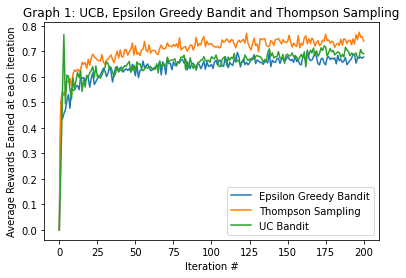

<Figure size 432x288 with 0 Axes>

In [6]:
import numpy as np
#import MDP
#import RL2
import matplotlib.pyplot as plt


def sampleBernoulli(mean):
    ''' function to obtain a sample from a Bernoulli distribution

    Input:
    mean -- mean of the Bernoulli
    
    Output:
    sample -- sample (0 or 1)
    '''

    if np.random.rand(1) < mean:
        return 1
    else:
        return 0


# Multi-arm bandit problems (3 arms with probabilities 0.25, 0.5 and 0.75)
T = np.array([[[1]], [[1]], [[1]]])
R = np.array([[0.25], [0.5], [0.75]])
discount = 0.999
mdp = MDP(T, R, discount)
banditProblem = RL2(mdp, sampleBernoulli)


fig = plt.figure()
plt.title("Graph 1: UCB, Epsilon Greedy Bandit and Thompson Sampling")
plt.xlabel("Iteration #")
plt.ylabel("Average Rewards Earned at each iteration")

#Epsilon greedy strategy Graph Generation
TRIALS = 1000
N_ITERATIONS = 200

average_rewards = None
for i in range(1,(TRIALS+1)):
    rewards = banditProblem.epsilonGreedyBandit(nIterations=N_ITERATIONS)
    if average_rewards is None:
        average_rewards = rewards
    else:
        average_rewards = (((average_rewards * (i-1)) + rewards) / i)

plt.plot(range(len(average_rewards)), average_rewards, label= "Epsilon Greedy Bandit")

#thompsonSamplingBandit Graph generation

average_rewards = None
for i in range(1,(TRIALS+1)):
    rewards = banditProblem.thompsonSamplingBandit(prior=np.ones([mdp.nActions,2]),nIterations=N_ITERATIONS)
    if average_rewards is None:
        average_rewards = rewards
    else:
        average_rewards = (((average_rewards * (i-1)) + rewards) / i)

plt.plot(range(len(average_rewards)), average_rewards, label= "Thompson Sampling")

#UC Bandit Graph generation

average_rewards = None
for i in range(1,(TRIALS+1)):
    rewards = banditProblem.UCBbandit(nIterations=N_ITERATIONS)
    if average_rewards is None:
        average_rewards = rewards
    else:
        average_rewards = (((average_rewards * (i-1)) + rewards) / i)

#Generates log curve
plt.plot(range(len(average_rewards)), average_rewards, label= "UC Bandit")


plt.legend(loc='best')
plt.savefig('A2_Part1.png', bbox_inches='tight')
plt.show()
plt.close()
plt.cla()
plt.clf()


# Assignment 2 Part 1:

The graph for UCB, Epsilon Greedy Bandit and Thompson Sampling is provided below for 200 iterations.

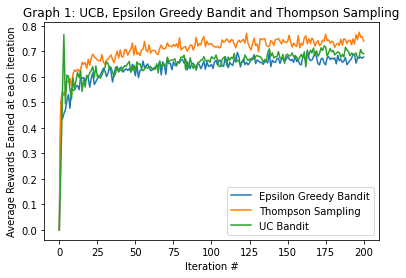

From the above graph, we see that all of the bandit algorithm results are converging towards 0.7~ 0.8 after 200 iterations. The convergence property is matches up with the expected results for all three algorithms. 

**ϵ-greedy bandit algorithm**

For ϵ-greedy, the average reward increases logrithmically with the number of iteration. This is because we chose ϵ = 1 / # iterations instead of a constant value. If this was constant, the ϵ-greedy curve would have been linear instead of logrithmic, which follows the theoratical gurantee for *ϵ-greedy bandit algorithm*.



**UC Bandit algorithm**

For UC Bandit algorithm, average rewards increases very fast at the beginning but in later iterations - the rewards are a bit lower than the beginning one, and it follows a logrithmic curve similar to **ϵ-greedy bandit algorithm** to reach convergence. The rewards at the beginning and after a few iterations may seem a bit surprising. However, this could be explained by the theorem behind UCB algorithm.

We know in UCB, Chosen action $a = argmax_{a} {({R^{̃}}(a) + √\frac{2log(n)}{n_{a}})}$, where ${{R^{̃}}(a) }$ is the empirical mean reward for action ${a}$. 

In 1st iteration, emphirical mean reward for all actions are 0, and ${n_{a}}$ is 0 for all actions. This results in equal oppertunity for any action to be picked in the first iteration. Once an arm is chosen, that arm is chosen again for a couple of times in the first few iterations, resulting in a higher average reward for the first few iterations. But as the trial progresses, the term $√{(\frac{2log(n)}{n_{a}})}$ increases, ensuring all actions are tried infinitely often. This results in reducing average rewards in later iterations with eventual logrithmic convergence to a reward. 

Theoratically, UCB performs better than $ϵ$-greedy, which is also reflected in this graph above. 

**Thompson Sampling**

Similar to ϵ-greedy and UC Bandit algorithm - average rewards in each iteration logarithmicly converges to a value. As iterations increase, emphirical means become less stochastic reducing exploration. As exploration is reduced, certain actions are chosen with increased probability - increasing average rewards. 